In [1]:
import pandas as pd
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np  

In [2]:
from data_utils import get_model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = "cvcl"
model, transform = get_model(model_name, device)
layers = "vision_encoder.model.layer1,vision_encoder.model.layer2,vision_encoder.model.layer3,vision_encoder.model.layer4"
layers = layers.split(",") # list of layers to extract features

Loading CVCL...
Invalid backbone, set to resnext50


Lightning automatically upgraded your loaded checkpoint from v1.5.8 to v2.2.1. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../.cache/huggingface/hub/models--wkvong--cvcl_s_dino_resnext50_embedding/snapshots/fe96aa69683bad69e5dd5195fc874a3edb8cb691/cvcl_s_dino_resnext50_embedding.ckpt`
/home/xke001/miniconda3/envs/cvcl/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'vision_encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['vision_encoder'])`.
/home/xke001/miniconda3/envs/cvcl/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'text_encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['text_encoder'])`.


Successfully loaded CVCL-resnext50


Loading dataset: object-trial


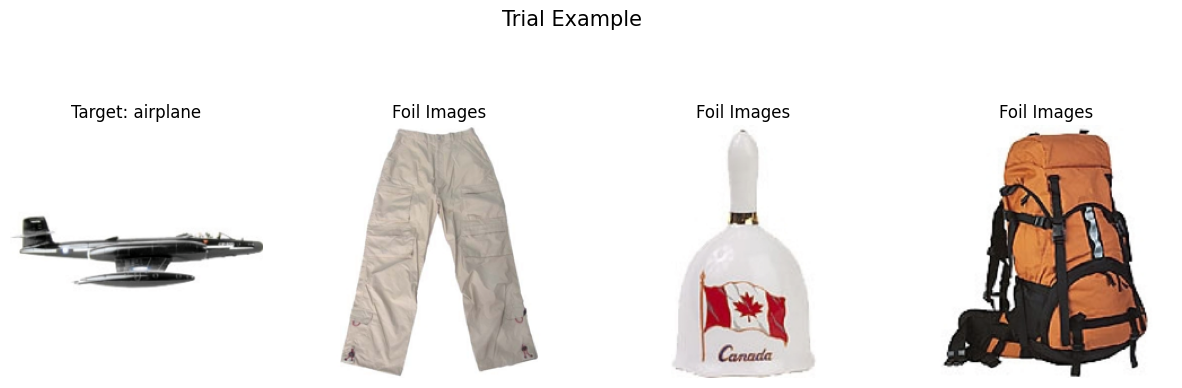

In [3]:
import matplotlib.pyplot as plt
from data_utils import get_dataset  
import torchvision.transforms as transforms

data = get_dataset(dataset_name='object-trial', transform=transform, trials_file='/home/xke001/demo/zero-shot/datasets/trials/object_5_3_42.json')
imgs, label = data[0]

inv_transform = transforms.Compose([
    transforms.Normalize(
        mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
        std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
    ),
    transforms.ToPILImage()
])


fig, ax = plt.subplots(1, len(imgs), figsize=(15, 5))
fig.suptitle("Trial Example", fontsize=15)

for i, img_tensor in enumerate(imgs):
    img = inv_transform(img_tensor)

    ax[i].imshow(img)
    ax[i].axis('off')
    
    if i == 0:
        ax[i].set_title(f"Target: {label}",fontsize=12)
    else:
        ax[i].set_title(f"Foil Images",fontsize=12)
        
plt.show()

In [4]:
import utils
import models.neuron_concept_mapper

import importlib
importlib.reload(utils)
importlib.reload(models.neuron_concept_mapper)
from models.feature_extractor import FeatureExtractor
from models.zs_trial_predic import ZSTrialPredic


feature_extractor = FeatureExtractor(model_name, model, device)
classifier = ZSTrialPredic(feature_extractor)
mapper = models.neuron_concept_mapper.NeuronConceptMapper('neuron_concept/cvcl_broden_broden.csv')

with torch.no_grad():
    activations, hooks = utils.register_hooks(model, layers, mode='avg') 
    img_features = feature_extractor.get_img_feature(imgs)
    img_features = feature_extractor.norm_features(img_features)
    
    for layer in layers:
        if activations[layer]:
            activations[layer] = torch.stack(activations[layer], dim=0)
    concept_info = mapper.get_concepts(activations, top_k=2, thres_param=None, mode='per_layer')
    utils.remove_hooks(hooks)

    concepts = mapper.compose_concepts(concept_info)
    concepts = ', '.join(concepts)
    concept_features = feature_extractor.get_concept_feature(concepts)
    concept_features = feature_extractor.norm_features(concept_features)
    print(concepts)
        # txt_features = 

RuntimeError: a Tensor with 256 elements cannot be converted to Scalar

In [7]:
# print("Shape of activations:", activations.shape)
print("Sample activation:", activations[0][0])

KeyError: 0

In [ ]:
print(concepts)

Flat activations shape: torch.Size([2, 768])
Indices of top k activations: tensor([[257,   1],
        [257,   1]])
Mask shape: torch.Size([2, 768])
Mask view as: torch.Size([2, 768])
Global index: 1
Corresponding layer: vision_encoder.model.layer1
Local index within the layer: 1
Global index: 257
Corresponding layer: vision_encoder.model.layer2
Local index within the layer: 1
Global index: 769
Corresponding layer: vision_encoder.model.layer1
Local index within the layer: 1
Global index: 1025
Corresponding layer: vision_encoder.model.layer2
Local index within the layer: 1
{0: {'vision_encoder.model.layer1': [{'unit': 1, 'concept': 'chequered', 'similarity': 1.5831299, 'activation': 1.0}], 'vision_encoder.model.layer2': [{'unit': 1, 'concept': 'blackboard', 'similarity': 1.4670105, 'activation': 1.0}]}, 1: {'vision_encoder.model.layer1': [{'unit': 1, 'concept': 'chequered', 'similarity': 1.5831299, 'activation': 1.0}], 'vision_encoder.model.layer2': [{'unit': 1, 'concept': 'blackboard',